In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.2-bin-hadoop2.7/
spark-3.0.2-bin-hadoop2.7/R/
spark-3.0.2-bin-hadoop2.7/R/lib/
spark-3.0.2-bin-hadoop2.7/R/lib/sparkr.zip
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/shell.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/general.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/index.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/R/
spark-3.0.2-

In [30]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as PLT

spark = SparkSession.builder.getOrCreate()

In [10]:
spark.read.csv("Customer.csv", header=True).createOrReplaceTempView("Customer")
spark.read.csv("Part.csv", header=True).createOrReplaceTempView("Part")
spark.read.csv("Staff.csv", header=True).createOrReplaceTempView("Staff")
spark.read.csv("Supplier.csv", header=True).createOrReplaceTempView("Supplier")
spark.read.csv("TransactionDetail.csv", header=True).createOrReplaceTempView("DetailTransaction")
spark.read.csv("TransactionHeader.csv", header=True).createOrReplaceTempView("HeaderTransaction")

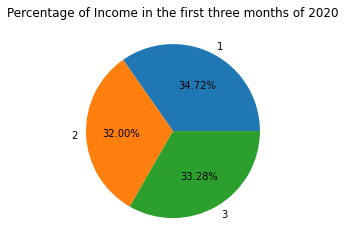

In [51]:
#a.	Show the percentage of income within the first three months of year 2020 in 
# which the part price is 500 and above using pie plot
data = spark.sql("""
    SELECT MONTH(HT.TransactionDate) AS TransactionMonth, SUM(P.Price * DT.Quantity) AS Income
      FROM Part P
      JOIN DetailTransaction DT ON P.PartID = DT.PartID
      JOIN HeaderTransaction HT ON DT.TransactionID = HT.TransactionID
      WHERE YEAR(HT.TransactionDate) = 2020 AND MONTH(HT.TransactionDate) BETWEEN '01' and '03' AND P.Price > 500
      GROUP BY MONTH(TransactionDate)
    ORDER BY MONTH(TransactionDate)
""").toPandas()

PLT.pie(data["Income"], labels=data["TransactionMonth"], autopct="%.2f%%")
PLT.title("Percentage of Income in the first three months of 2020")
PLT.show()

#display(data)

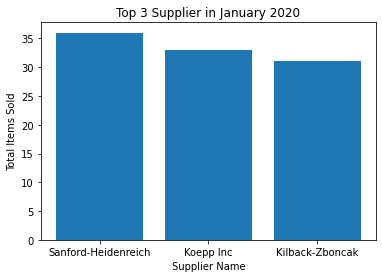

In [61]:
# b. Show top 3 supplier in which the part is bought the most in January 2020 using bar plot.

data = spark.sql("""
    SELECT S.Name AS SupplierName, SUM(DT.Quantity) AS Total_Items_Sold
    FROM Supplier S
    JOIN Part P ON S.SupplierID = P.SupplierID
    JOIN DetailTransaction DT ON P.PartID = DT.PartID
    JOIN HeaderTransaction HT ON DT.TransactionID = HT.TransactionID
    WHERE MONTH(HT.TransactionDate) = '01'
    GROUP BY(SupplierName)
    ORDER BY(Total_Items_Sold) DESC
    LIMIT 3
""").toPandas()

PLT.bar(data["SupplierName"], data["Total_Items_Sold"])
PLT.title("Top 3 Supplier in January 2020")
PLT.xlabel("Supplier Name")
PLT.ylabel("Total Items Sold")
PLT.show()

#display(data)

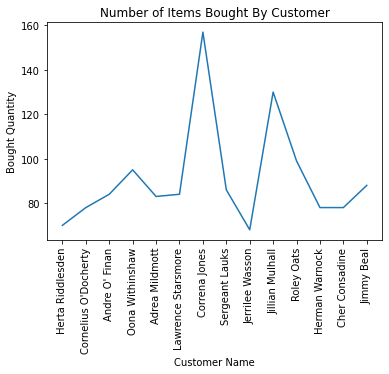

In [120]:
#c. Show the number of items bought by customer that has at least done multiple 
# transaction with female staff and total items bought is more than 50 using line plot.

data = spark.sql("""
    SELECT SUM(DT.Quantity) AS Quantity, C.Name AS Customer_Name
    FROM DetailTransaction DT
    JOIN HeaderTransaction HT ON DT.TransactionID = HT.TransactionID
    JOIN Staff S ON HT.StaffID = S.StaffID
    JOIN Customer C ON HT.CustomerID = C.CustomerID
    WHERE S.Gender = 'Female'
    GROUP BY (Customer_Name)
    HAVING COUNT(DT.TransactionID) > 1 AND COUNT(HT.CustomerID) > 1 AND SUM(Quantity) > 50
""").toPandas()

PLT.plot(data["Customer_Name"], data["Quantity"])
PLT.title("Number of Items Bought By Customer")
PLT.xlabel("Customer Name")
PLT.ylabel("Bought Quantity")
PLT.xticks(range(0,14), rotation='vertical')
PLT.show()

#display(data)

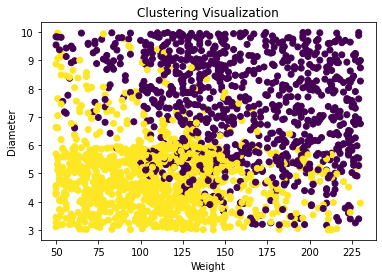

Accuracy: 19.1%


In [143]:
testing = spark.read.csv("TomatoTest.csv", header=True, inferSchema=True)
training = spark.read.csv("TomatoTrain.csv", header=True, inferSchema=True)

columns = ["Weight", "Diameter", "Color"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Weight", "Diameter", "Color", "Hybrid")
training = training.select(columns)

from pyspark.sql.functions import when

testing = testing.withColumn(
  "Color", when(testing["Color"] == "Red", 0)
    .when(testing["Color"] == "Dark Red", 1)
    .when(testing["Color"] == "Orange", 2)
)

testing = testing.withColumn(
  "Hybrid", when(testing["Hybrid"] == "No", 0)
    .when(testing["Hybrid"] == "Yes", 1)
)

training = training.withColumn(
  "Color", when(training["Color"] == "Red", 0)
    .when(training["Color"] == "Dark Red", 1)
    .when(training["Color"] == "Orange", 2)
)
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols = columns, outputCol = "assembled")
scaler = StandardScaler(inputCol="assembled", outputCol = "features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2)
model = kmeans.fit(training)
data = model.transform(testing).toPandas()

PLT.scatter(
    data["Weight"],
    data["Diameter"],
    c = data["prediction"]
)

PLT.title("Clustering Visualization")
PLT.xlabel("Weight")
PLT.ylabel("Diameter")
PLT.show()

x = 0
for idx, row in data.iterrows():
  if row["Hybrid"] == row["prediction"]:
    x+=1

acc = x / len(data) * 100
print(f'Accuracy: {acc}%')

#testing.show()
#training.show()

In [140]:
display(data)

,Weight,Diameter,Color,Hybrid,assembled,features,prediction
0,215,8.35,1,1,"[215.0, 8.35, 1.0]","[4.5937434916554745, 4.329000450395528, 1.3539...",0
1,118,5.43,1,0,"[118.0, 5.43, 1.0]","[2.5212173582109116, 2.815146400676373, 1.3539...",1
2,128,9.72,0,0,"[128.0, 9.72, 0.0]","[2.7348798461948873, 5.039267590161022, 0.0]",0
3,60,5.87,1,0,"[60.0, 5.87, 1.0]","[1.2819749279038535, 3.0432613944696705, 1.353...",1
4,213,3.00,0,1,"[213.0, 3.0, 0.0]","[4.55101099405868, 1.5553295031361176, 0.0]",1
...,...,...,...,...,...,...,...
1995,52,9.38,1,0,"[52.0, 9.38, 1.0]","[1.1110449375166729, 4.862996913138929, 1.3539...",0
1996,118,5.88,0,0,"[118.0, 5.88, 0.0]","[2.5212173582109116, 3.0484458261467906, 0.0]",1
1997,107,9.06,1,1,"[107.0, 9.06, 1.0]","[2.2861886214285385, 4.697095099471076, 1.3539...",0
1998,168,3.20,2,1,"[168.0, 3.2, 2.0]","[3.5895297981307897, 1.6590181366785257, 2.707...",0
